In [1]:
%matplotlib inline



# Implement a new converter

.. index:: custom converter

By default, :epkg:`sklearn-onnx` assumes that a classifier
has two outputs (label and probabilities), a regressor
has one output (prediction), a transform has one output
(the transformed data). This example assumes the model to
convert is one of them. In that case, a new converter requires
in fact two functions:

* a shape calculator: it defines the output shape and type
  based on the model and input type,
* a converter: it actually builds an ONNX graph equivalent
  to the prediction function to be converted.

This example implements both components for a new model.

## Custom model

Let's implement a simple custom model using
:epkg:`scikit-learn` API. The model is preprocessing
which decorrelates correlated random variables.
If *X* is a matrix of features, $V=\frac{1}{n}X'X$
is the covariance matrix. We compute $X V^{1/2}$.


In [2]:
from mlprodict.onnxrt import OnnxInference
from pyquickhelper.helpgen.graphviz_helper import plot_graphviz
import pickle
from io import BytesIO
import numpy
from numpy.testing import assert_almost_equal
from onnxruntime import InferenceSession
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.datasets import load_iris
from skl2onnx.common.data_types import guess_numpy_type
from skl2onnx import to_onnx
from skl2onnx import update_registered_converter
from skl2onnx.algebra.onnx_ops import OnnxMatMul, OnnxSub


class DecorrelateTransformer(TransformerMixin, BaseEstimator):
    """
    Decorrelates correlated gaussian features.

    :param alpha: avoids non inversible matrices
        by adding *alpha* identity matrix

    *Attributes*

    * `self.mean_`: average
    * `self.coef_`: square root of the coveriance matrix
    """

    def __init__(self, alpha=0.):
        BaseEstimator.__init__(self)
        TransformerMixin.__init__(self)
        self.alpha = alpha

    def fit(self, X, y=None, sample_weights=None):
        if sample_weights is not None:
            raise NotImplementedError(
                "sample_weights != None is not implemented.")
        self.mean_ = numpy.mean(X, axis=0, keepdims=True)
        X = X - self.mean_
        V = X.T @ X / X.shape[0]
        if self.alpha != 0:
            V += numpy.identity(V.shape[0]) * self.alpha
        L, P = numpy.linalg.eig(V)
        Linv = L ** (-0.5)
        diag = numpy.diag(Linv)
        root = P @ diag @ P.transpose()
        self.coef_ = root
        return self

    def transform(self, X):
        return (X - self.mean_) @ self.coef_


def test_decorrelate_transformer():
    data = load_iris()
    X = data.data

    dec = DecorrelateTransformer()
    dec.fit(X)
    pred = dec.transform(X)
    cov = pred.T @ pred
    cov /= cov[0, 0]
    assert_almost_equal(numpy.identity(4), cov)

    dec = DecorrelateTransformer(alpha=1e-10)
    dec.fit(X)
    pred = dec.transform(X)
    cov = pred.T @ pred
    cov /= cov[0, 0]
    assert_almost_equal(numpy.identity(4), cov)

    st = BytesIO()
    pickle.dump(dec, st)
    dec2 = pickle.load(BytesIO(st.getvalue()))
    assert_almost_equal(dec.mean_, dec2.mean_)
    assert_almost_equal(dec.coef_, dec2.coef_)
    assert id(dec.mean_) != id(dec2.mean_)
    assert id(dec.coef_) != id(dec2.coef_)


test_decorrelate_transformer()

data = load_iris()
X = data.data

dec = DecorrelateTransformer()
dec.fit(X)
pred = dec.transform(X[:5])
print(pred)

[[ 0.0167562   0.52111756 -1.24946737 -0.56194325]
 [-0.0727878  -0.80853732 -1.43841018 -0.37441392]
 [-0.69971891 -0.09950908 -1.2138161  -0.3499275 ]
 [-1.13063404 -0.13540568 -0.79087008 -0.73938966]
 [-0.35790036  0.91900236 -1.04034399 -0.6509266 ]]


Trained coefficients.



In [3]:
print(dec.mean_)
print(dec.coef_)

[[5.84333333 3.05733333 3.758      1.19933333]]
[[ 2.8040383  -0.94252732 -1.22382017  0.36769632]
 [-0.94252732  3.03632069  0.86741369 -0.52213719]
 [-1.22382017  0.86741369  1.93652687 -2.02453122]
 [ 0.36769632 -0.52213719 -2.02453122  4.83455725]]


## Conversion into ONNX

Let's try to convert it and see what happens.



In [4]:
try:
    to_onnx(dec, X.astype(numpy.float32))
except Exception as e:
    print(e)

Unable to find a shape calculator for type '<class '__main__.DecorrelateTransformer'>'.
It usually means the pipeline being converted contains a
transformer or a predictor with no corresponding converter
implemented in sklearn-onnx. If the converted is implemented
in another library, you need to register
the converted so that it can be used by sklearn-onnx (function
update_registered_converter). If the model is not yet covered
by sklearn-onnx, you may raise an issue to
https://github.com/onnx/sklearn-onnx/issues
to get the converter implemented or even contribute to the
project. If the model is a custom model, a new converter must
be implemented. Examples can be found in the gallery.



This error means there is no converter associated
to *DecorrelateTransformer*. Let's implement it.
It requires the two following
functions, a shape calculator and a converter
with the same signature as below.
First the shape calculator. We retrieve the input type
add tells the output type has the same type,
the same number of rows and a specific number of columns.



In [5]:
def decorrelate_transformer_shape_calculator(operator):
    op = operator.raw_operator
    input_type = operator.inputs[0].type.__class__
    # The shape may be unknown. *get_first_dimension*
    # returns the appropriate value, None in most cases
    # meaning the transformer can process any batch of observations.
    input_dim = operator.inputs[0].get_first_dimension()
    output_type = input_type([input_dim, op.coef_.shape[1]])
    operator.outputs[0].type = output_type

The converter. One thing we need to pay attention to
is the target opset. This information is important
to make sure that every node is defined following the
specifications of that opset.



In [6]:
def decorrelate_transformer_converter(scope, operator, container):
    op = operator.raw_operator
    opv = container.target_opset
    out = operator.outputs

    # We retrieve the unique input.
    X = operator.inputs[0]

    # In most case, computation happen in floats.
    # But it might be with double. ONNX is very strict
    # about types, every constant should have the same
    # type as the input.
    dtype = guess_numpy_type(X.type)

    # We tell in ONNX language how to compute the unique output.
    # op_version=opv tells which opset is requested
    Y = OnnxMatMul(
        OnnxSub(X, op.mean_.astype(dtype), op_version=opv),
        op.coef_.astype(dtype),
        op_version=opv, output_names=out[:1])
    Y.add_to(scope, container)

We need to let *skl2onnx* know about the new converter.



In [7]:
update_registered_converter(
    DecorrelateTransformer, "SklearnDecorrelateTransformer",
    decorrelate_transformer_shape_calculator,
    decorrelate_transformer_converter)


onx = to_onnx(dec, X.astype(numpy.float32))

sess = InferenceSession(onx.SerializeToString())

exp = dec.transform(X.astype(numpy.float32))
got = sess.run(None, {'X': X.astype(numpy.float32)})[0]


def diff(p1, p2):
    p1 = p1.ravel()
    p2 = p2.ravel()
    d = numpy.abs(p2 - p1)
    return d.max(), (d / numpy.abs(p1)).max()


print(diff(exp, got))

(6.046576279672422e-07, 0.000295141707503972)


Let's check it works as well with double.



In [8]:
onx = to_onnx(dec, X.astype(numpy.float64))

sess = InferenceSession(onx.SerializeToString())

exp = dec.transform(X.astype(numpy.float64))
got = sess.run(None, {'X': X.astype(numpy.float64)})[0]
print(diff(exp, got))

(1.1102230246251565e-15, 3.4753904038774583e-13)


The differences are smaller with double as expected.



## Final graph



In [9]:
current_path = %env PATH
%env PATH=/opt/conda/envs/onnx_training/bin:$current_path

env: PATH=/opt/conda/envs/onnx_training/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin


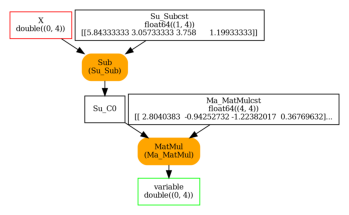

In [10]:
oinf = OnnxInference(onx)
ax = plot_graphviz(oinf.to_dot())
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

## Test saving to disk and reloading model for prediction

In [11]:
# save model as onnx file
with open('decorrelate_transformer.onnx', 'wb') as f:
    f.write(onx.SerializeToString())

In [12]:
# retstore the decorrelate transformer and score again

sess2 = InferenceSession('decorrelate_transformer.onnx')

input_name = sess2.get_inputs()[0].name
label_name = sess2.get_outputs()[0].name
prediction = sess2.run([label_name], {'X': X.astype(numpy.float64)})[0]

print('restored model', diff(exp, prediction))

restored model (1.1102230246251565e-15, 3.4753904038774583e-13)
